In [6]:
!pip install transformers

In [7]:
!pip install torch


In [8]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

# Torch ML libraries
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

# Misc.
import warnings
warnings.filterwarnings('ignore')

In [9]:
# Set initial configurations and constants

# 1. Set the inline backend figure format to 'retina' for higher resolution in Jupyter Notebook
%config InlineBackend.figure_format='retina'

# 2. Configure Seaborn styles for visualizations
# - Use white grid style, muted color palette, and adjust font scale for readability
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

# 3. Define a custom color palette for Seaborn plots
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

# 4. Set default figure size for plots
rcParams['figure.figsize'] = 12, 8

# 5. Set a random seed for reproducibility
# - This ensures consistent results when splitting data and initializing models
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# 6. Set the computation device
# - Checks if a GPU is available; if not, defaults to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

DATASET

In [10]:
df_balanced = pd.read_csv('df_balanced.csv')
df_balanced.shape

(12630, 3)

In [11]:
df_balanced.head()

,Review,Rating,Sentiment
0,We a bunch of friends went for a holiday dinne...,1.0,0
1,We went for lunch buffet. Food taste is averag...,2.0,0
2,Super,5.0,1
3,"I ordered chicken fried rice, there were not t...",2.0,0
4,the dish was extremely oily. the tandoori roti...,2.0,0


DATA PREPROCESSING

In [12]:
!pip install ipywidgets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 24.0 MB/s eta 0:00:00


In [13]:
class_names = ['negative','positive']

In [14]:
# Set the model name
MODEL_NAME = 'bert-base-cased'

# Build a BERT based tokenizer
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [15]:
# Some of the common BERT tokens
print(tokenizer.sep_token, tokenizer.sep_token_id) # marker for ending of a sentence
print(tokenizer.cls_token, tokenizer.cls_token_id) # start of each sentence, so BERT knows we’re doing classification
print(tokenizer.pad_token, tokenizer.pad_token_id) # special token for padding
print(tokenizer.unk_token, tokenizer.unk_token_id) # tokens not found in training set

[SEP] 102
[CLS] 101
[PAD] 0
[UNK] 100


In [16]:
# Store length of each review
token_lens = []

# Iterate through the Review slide
for txt in df_balanced.Review:
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Text(0.5, 0, 'Token count')

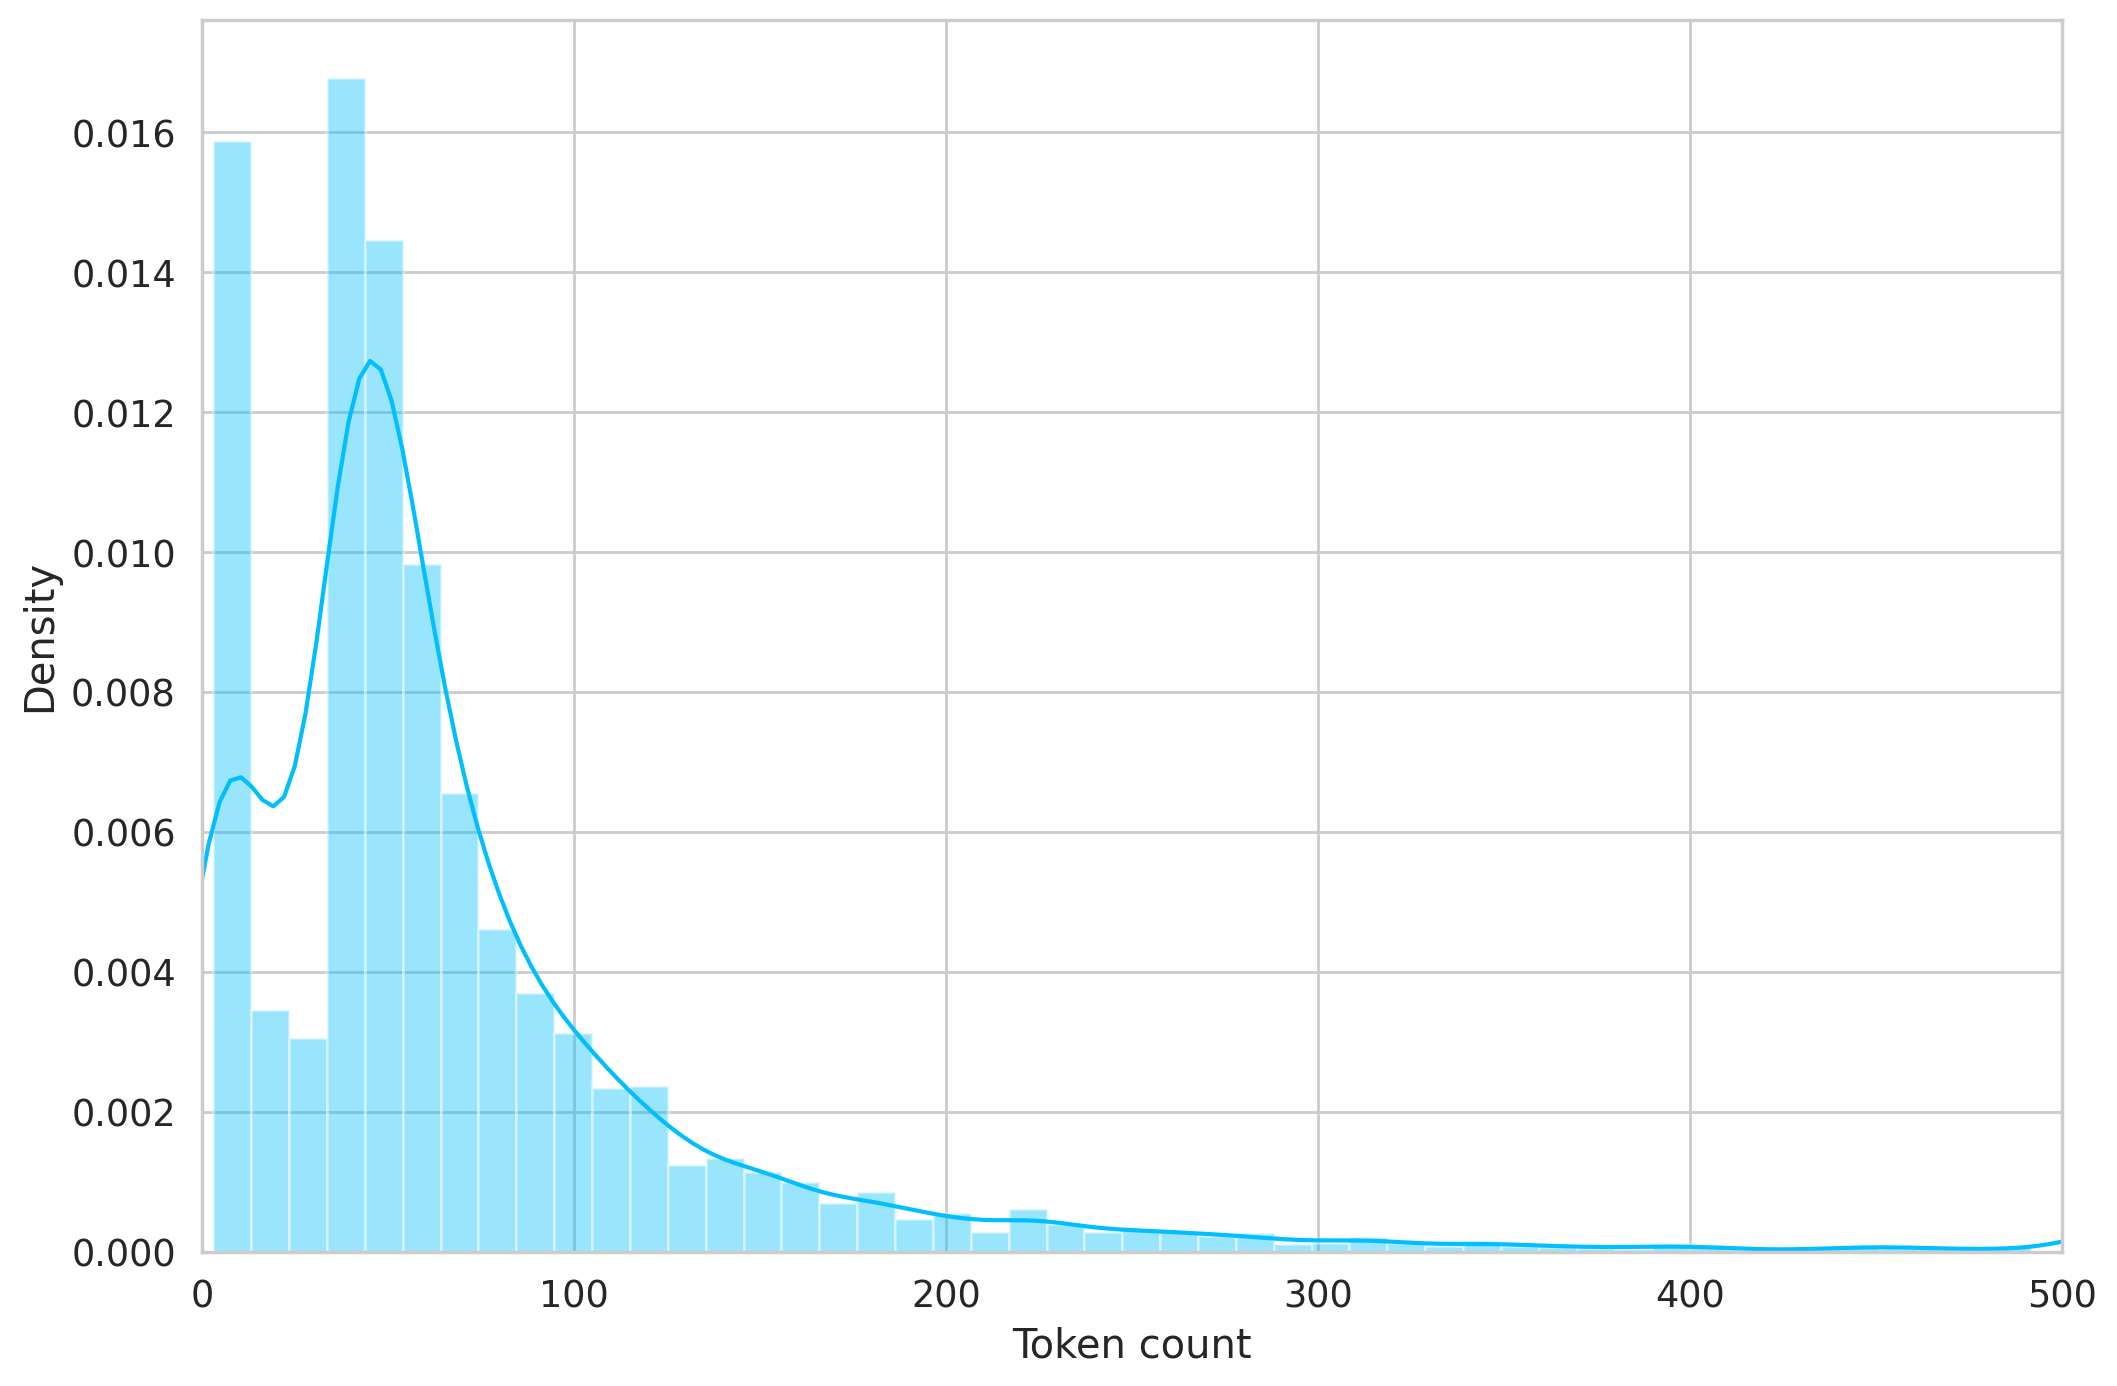

In [17]:

# plot the distribution of review lengths
sns.distplot(token_lens)
plt.xlim([0, 500]);
plt.xlabel('Token count')

In [18]:
MAX_LEN = 400

In [19]:


class GPReviewDataset(Dataset):
    # Constructor to initialize the dataset with reviews, targets, tokenizer, and max length
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews        # List of review texts
        self.targets = targets        # List of target labels (e.g., sentiment)
        self.tokenizer = tokenizer    # BERT tokenizer for converting text to tokens
        self.max_len = max_len        # Maximum length for tokenized reviews to ensure consistent input size

    # Returns the total number of samples in the dataset
    def __len__(self):
        return len(self.reviews)      # Returns the number of reviews in the dataset

    # Retrieves a single item (review and target) by its index
    def __getitem__(self, item):
        review = str(self.reviews[item])  # Get the review text at the specified index
        target = self.targets[item]       # Get the target label at the specified index

        # Encode the review text using the tokenizer
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,       # Add [CLS] and [SEP] tokens to the review
            max_length=self.max_len,       # Set maximum length of tokens (truncated/padded)
            return_token_type_ids=False,   # Not needed for single-sentence tasks
            pad_to_max_length=True,        # Pad reviews shorter than max_len with [PAD] tokens
            return_attention_mask=True,    # Generate attention mask (1 for tokens, 0 for padding)
            return_tensors='pt',           # Return PyTorch tensors
        )

        # Return a dictionary with the tokenized review, attention mask, and target label
        return {
            'review_text': review,                                  # Original review text
            'input_ids': encoding['input_ids'].flatten(),           # Token IDs for the review
            'attention_mask': encoding['attention_mask'].flatten(), # Attention mask for padding
            'targets': torch.tensor(target, dtype=torch.long)       # Target label as a tensor
        }


In [20]:
#Create a 80% train data and 10% test and 10% validation data
df_train, df_test = train_test_split(df_balanced, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

print(df_train.shape, df_val.shape, df_test.shape)

(10104, 3) (1263, 3) (1263, 3)


In [21]:
#Create a dataloader to release data in batches.
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        reviews=df.Review.to_numpy(),
        targets=df.Sentiment.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0
    )

Sentiment Classification with BERT and Hugging Face

In [22]:
# Define the Sentiment Classifier
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes, dropout_rate=0.3):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(MODEL_NAME)
        self.drop = nn.Dropout(p=dropout_rate)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        output = self.drop(pooled_output)
        return self.out(output)
#We use a dropout layer for some regularization and a fully-connected layer for our output.
#We are returning the raw output of the last layer since that is required for the cross-entropy loss function in PyTorch to work.
#Create an instance and move it to the GPU

Training Phase

In [23]:
# Set the loss function
loss_fn = nn.CrossEntropyLoss().to(device)

In [24]:
# Function for a single training iteration
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        # Backward prop
        loss.backward()

        # Gradient Descent
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)


In [25]:
#function to evaluate the model
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            # Get model ouptuts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

In [26]:
from collections import defaultdict
import torch
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import gc

# Function to train and evaluate with given parameters
def train_and_evaluate(model, train_data_loader, val_data_loader, loss_fn, optimizer, scheduler, epochs, device):
    history = defaultdict(list)
    best_accuracy = 0

    for epoch in range(epochs):
        train_acc, train_loss = train_epoch(
            model, train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train)
        )

        val_acc, val_loss = eval_model(
            model, val_data_loader, loss_fn, device, len(df_val)
        )

        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)

        if val_acc > best_accuracy:
            best_accuracy = val_acc
            torch.save(model.state_dict(), 'best_model_state.bin')

    return best_accuracy



In [27]:
# Function to evaluate and print classification report and confusion matrix
def evaluate_model(model, data_loader, device):
    y_true = []
    y_pred = []

    model.eval()
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)

            y_true.extend(targets.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Print classification report
    print("Classification Report:")
    print(classification_report(y_true, y_pred))

    # Plot confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()



Training with config1: {'learning_rate': 1e-05, 'batch_size': 16, 'dropout_rate': 0.1, 'epochs': 2}


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Validation Accuracy for config1: tensor(0.9501, device='cuda:0', dtype=torch.float64)

Evaluation for config1:
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.95       605
           1       0.95      0.96      0.95       658

    accuracy                           0.95      1263
   macro avg       0.95      0.95      0.95      1263
weighted avg       0.95      0.95      0.95      1263



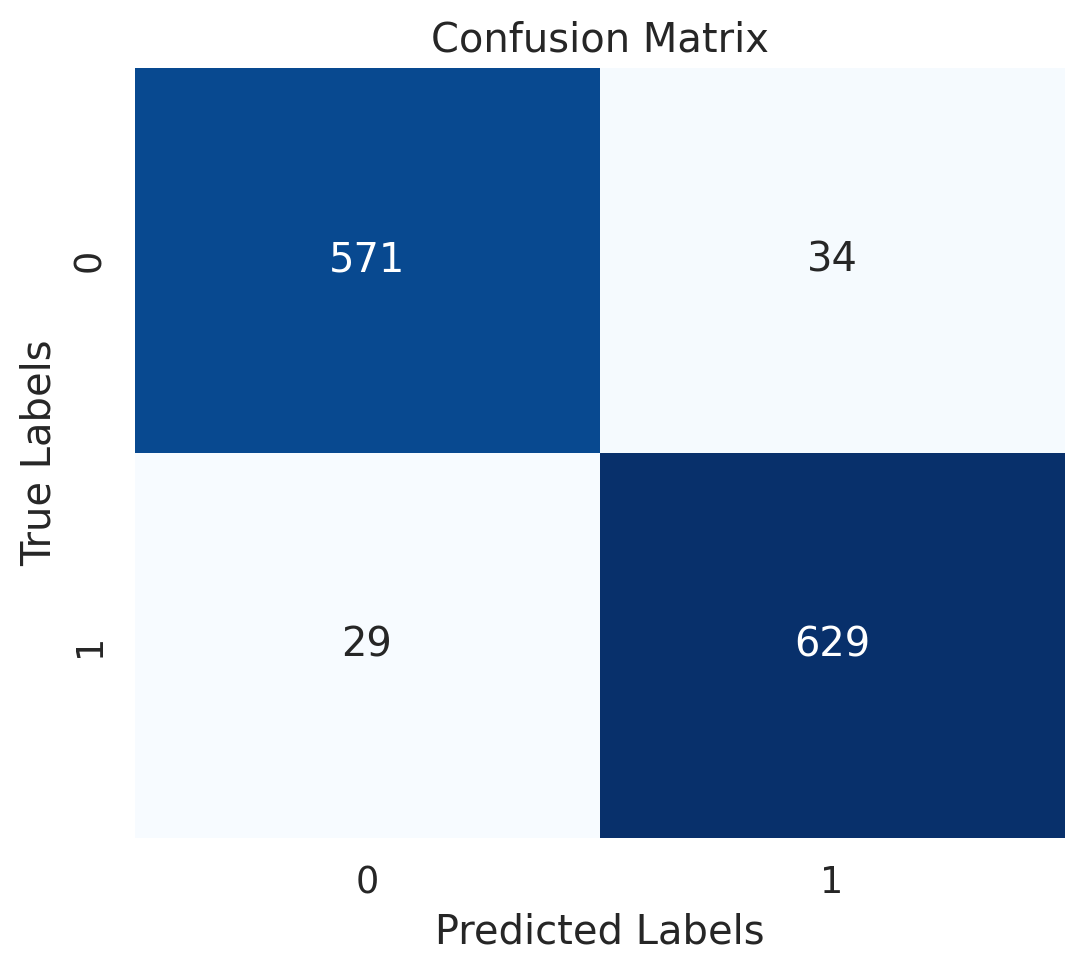

2462

In [28]:
# Configuration 1
config1 = {
    'learning_rate': 1e-5,
    'batch_size': 16,
    'dropout_rate': 0.1,
    'epochs': 2
}

print(f"Training with config1: {config1}")
model = SentimentClassifier(len(class_names), dropout_rate=config1['dropout_rate']).to(device)
optimizer = AdamW(model.parameters(), lr=config1['learning_rate'], correct_bias=False)
total_steps = len(df_train) * config1['epochs']
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, config1['batch_size'])
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, config1['batch_size'])

accuracy1 = train_and_evaluate(model, train_data_loader, val_data_loader, loss_fn, optimizer, scheduler, config1['epochs'], device)
print("Validation Accuracy for config1:", accuracy1)

# Evaluate and print report for config1
print("\nEvaluation for config1:")
evaluate_model(model, val_data_loader, device)

# Clear memory after the first configuration
del model, optimizer, scheduler, train_data_loader, val_data_loader
torch.cuda.empty_cache()
gc.collect()




Training with config2: {'learning_rate': 2e-05, 'batch_size': 20, 'dropout_rate': 0.3, 'epochs': 5}
Validation Accuracy for config2: tensor(0.9485, device='cuda:0', dtype=torch.float64)

Evaluation for config2:
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.97      0.95       605
           1       0.97      0.93      0.95       658

    accuracy                           0.95      1263
   macro avg       0.95      0.95      0.95      1263
weighted avg       0.95      0.95      0.95      1263



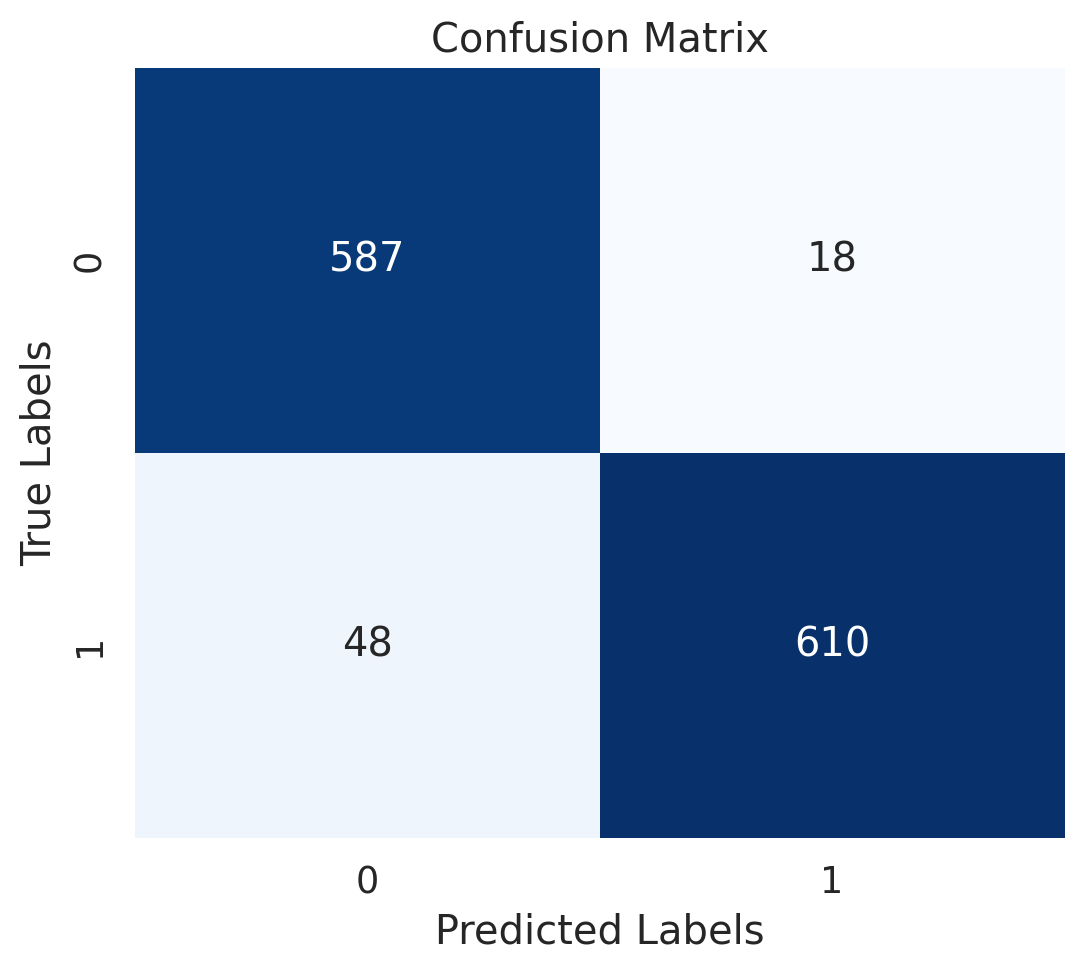

2453

In [29]:
# Configuration 2
config2 = {
    'learning_rate': 2e-5,
    'batch_size': 20,
    'dropout_rate': 0.3,
    'epochs': 5
}

print(f"\nTraining with config2: {config2}")
model = SentimentClassifier(len(class_names), dropout_rate=config2['dropout_rate']).to(device)
optimizer = AdamW(model.parameters(), lr=config2['learning_rate'], correct_bias=False)
total_steps = len(df_train) * config2['epochs']
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, config2['batch_size'])
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, config2['batch_size'])

accuracy2 = train_and_evaluate(model, train_data_loader, val_data_loader, loss_fn, optimizer, scheduler, config2['epochs'], device)
print("Validation Accuracy for config2:", accuracy2)

# Evaluate and print report for config2
print("\nEvaluation for config2:")
evaluate_model(model, val_data_loader, device)

# Clear memory after the second configuration
del model, optimizer, scheduler, train_data_loader, val_data_loader
torch.cuda.empty_cache()
gc.collect()


In [30]:
# Print the best configuration
if accuracy1 > accuracy2:
    print("Best Configuration:", config1)
    print("Best Validation Accuracy:", accuracy1)
else:
    print("Best Configuration:", config2)
    print("Best Validation Accuracy:", accuracy2)


Best Configuration: {'learning_rate': 1e-05, 'batch_size': 16, 'dropout_rate': 0.1, 'epochs': 2}
Best Validation Accuracy: tensor(0.9501, device='cuda:0', dtype=torch.float64)
